# Insurance Benefit Prediction 

# Content
* [Introduction](#intro)
* [Initialization](#initialization)
* [Data Exploration](#exploration)
* [Data Preprocessing](#preprocessing)
* [Exploratory Data Analysis (EDA)](#eda)
* [Task 1. Similar Customers](#task_1)
  * [Conclusion](#conclusion)
* [Task 2. Is Customer Likely to Receive Insurance Benefit?](#task_2)
  * [Calculating F1 Score on Unscaled Data](#unscaled)
  * [Calculating F1 Score on Scaled Data](#scaled)
  * [Calculating F1 Score on Dummy Model](#dummy)
* [Task 3. Regression (with Linear Regression)](#task_3)
  * [Linear Regression Model for Unscaled Data](#unscaled)
  * [Linear Regression Model for Scaled Data](#scaled)
  * [Conclusion](#conclusion)
* [Task 4. Obfuscating Data](#task_4)
* [Proof that Data Obfuscation Can Work with Linear Regression](#proof)
* [Testing Linear Regression with Data Obfuscation](#testing)
* [Findings](#findings)

## Introduction

The Sure Tomorrow insurance company wants to develop a model that will help the company's agents with marketing. The company wants to predict whether new customer's will likely receive an insurance benefit. Because the information used involves personal information, we must develop a data transformation algorithm that makes it hard to recover personal information. 

**Data Description**
* `Features`: insured person's gender, age, salary, and number of family members 
* `Target`: number of insurance benefits received by an insured person over the last five years

**Objectives:**
* Find customers who are similar to a given customer
* Predict whether a new customer is likely to receive an insurance benefit
* Predict the number of insurance benefits a new customer is likely to receive using a linear regression model 
* Protect clients' personal data without breaking the model 

## Initialization 

In [1]:
# Loading all libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import sklearn.metrics
import sklearn.neighbors 
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
# Loading the data
try:
  df = pd.read_csv('insurance_us.csv')
except:
  df = pd.read_csv('/datasets/insurance_us.csv')

## Data Exploration 

Description of data:

* `Gender`
* `Age`
* `Salary`
* `Family members`
* `Insurance benefits`

In [3]:
# Obtaining first five rows of the table
df.head()

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [4]:
# Obtaining number of rows and columns
shape = df.shape
print('The table has {} rows and {} columns'.format(shape[0], shape[1]))

The table has 5000 rows and 5 columns


In [5]:
# Obtaining general info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              5000 non-null   int64  
 1   Age                 5000 non-null   float64
 2   Salary              5000 non-null   float64
 3   Family members      5000 non-null   int64  
 4   Insurance benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Since each column has 5000 rows, our table contains no missing data

In [6]:
# Checking for duplicates
df.duplicated().sum()

153

There are 153 duplicates in our data. 

### Conclusion 

Our dataset contains 5000 rows and 5 columns. There are no missing values in our table, but there are duplicates. Column names also don't follow good rule of style. 

We will now preprocess our data to fix column names and deal with duplicates. 

## Data Preprocessing

In [7]:
# Changing column names to lowercase 
df.columns = df.columns.str.lower()

# Renaming columns
df = df.rename(columns={'family members': 'family_members', 'insurance benefits': 'insurance_benefits'})

# Checking to make sure column names have been properly fixed
df.columns

Index(['gender', 'age', 'salary', 'family_members', 'insurance_benefits'], dtype='object')

In [8]:
# Converting values in age column to int
df['age'] = df['age'].astype('int')

# Checking to see if age column has been properly converted
df['age'].dtype

dtype('int64')

In [9]:
# Removing duplicates
df = df.drop_duplicates().reset_index(drop=True)

# Checking to make sure duplicates have been dropped
df.duplicated().sum()

0

In [10]:
# Viewing info of data after manipulations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              4847 non-null   int64  
 1   age                 4847 non-null   int64  
 2   salary              4847 non-null   float64
 3   family_members      4847 non-null   int64  
 4   insurance_benefits  4847 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 189.5 KB


### Conclusion

We changed all column names to lower case and added snakecase to make column names easier to work with. Since the `age` column was written as float type, we changed it to int type. After duplicates were removed, we checked our data after manipulations and saw that the number of rows reduced from 5,000 to 4,847. 

Now that our dataset is clean, we will exploratory data analysis (EDA) to see if we can find patterns, relationships, or anomilies in our data.

## Exploratory Data Analysis (EDA)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


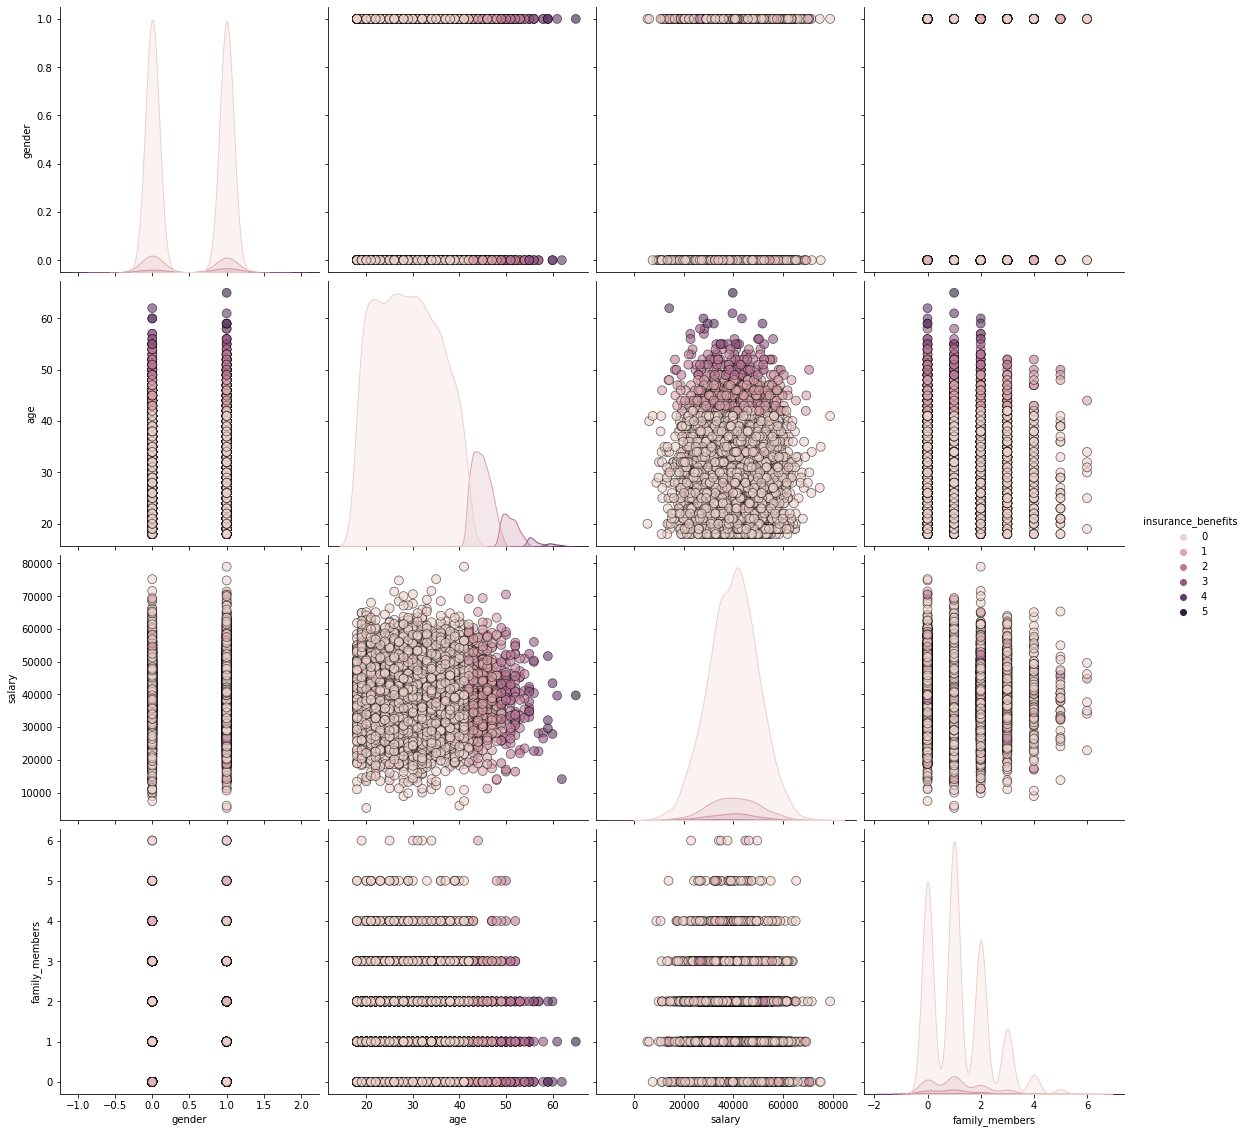

In [11]:
# Creating pariplot
sns.pairplot(df, hue = 'insurance_benefits', diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4)



We plotted multiple pairwise bivariate distributions in our dataset. Each variable is plotted against the rest of the variables. We colored our plot based off of `insurance_benefits` and can see certain patterns. For example, there seems to be a positive correlation with insurance benefit and age. There are more benefits the older you are. 

Since it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions), we will now use machine learning to:
* Find customers who ar esmilar to a given customer 
* Predict whether a new customer is likely to receive an insurance benefit 
* Predict the number of insurance benefits a new customer is likely to receive 

## Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

We will write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits will not be taken into account for this task. 

In [12]:
# Defining features
feature_names = ['gender', 'age', 'salary', 'family_members']

In [13]:
# Creating k nearest neighbors function
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names].values) 
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

In [14]:
# Scaling the data
feature_names = ['gender', 'age', 'salary', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [15]:
# Obtaining five random samples of our scaled data
df_scaled.sample(5)

,gender,age,salary,family_members,insurance_benefits
2483,0.0,0.476923,0.573418,0.166667,0
2070,0.0,0.446154,0.597468,0.333333,0
3797,1.0,0.938462,0.501266,0.166667,4
168,0.0,0.461538,0.472152,0.000000,0
592,0.0,0.538462,0.473418,0.000000,0


In [16]:
# Calculating euclidean distance with unscaled data
get_knn(df[feature_names], 0, 10, 'euclidean')

,gender,age,salary,family_members,distance
0,1,41,49600.0,1,0.000000
1992,1,41,49600.0,0,1.000000
1214,0,42,49600.0,0,1.732051
3916,1,44,49600.0,2,3.162278
3334,0,38,49600.0,0,3.316625
810,1,37,49600.0,2,4.123106
4520,0,45,49600.0,0,4.242641
2094,0,37,49600.0,2,4.242641
3790,1,36,49600.0,0,5.099020
2311,1,46,49600.0,2,5.099020


In [17]:
# Calculating euclidean distance with scaled data
get_knn(df_scaled[feature_names], 0, 10, 'euclidean')

,gender,age,salary,family_members,distance
0,1.0,0.630769,0.627848,0.166667,0.000000
2632,1.0,0.630769,0.634177,0.166667,0.006329
133,1.0,0.615385,0.636709,0.166667,0.017754
4720,1.0,0.646154,0.637975,0.166667,0.018418
3192,1.0,0.646154,0.651899,0.166667,0.028550
1550,1.0,0.615385,0.602532,0.166667,0.029624
2072,1.0,0.630769,0.596203,0.166667,0.031646
124,1.0,0.661538,0.635443,0.166667,0.031693
3541,1.0,0.615385,0.600000,0.166667,0.031815
3099,1.0,0.600000,0.611392,0.166667,0.034893


In [18]:
# Calculating Manhattan distance with unscaled data
get_knn(df[feature_names], 0, 10, 'cityblock')

,gender,age,salary,family_members,distance
0,1,41,49600.0,1,0.0
1992,1,41,49600.0,0,1.0
1214,0,42,49600.0,0,3.0
3916,1,44,49600.0,2,4.0
810,1,37,49600.0,2,5.0
3334,0,38,49600.0,0,5.0
2311,1,46,49600.0,2,6.0
3790,1,36,49600.0,0,6.0
2094,0,37,49600.0,2,6.0
4520,0,45,49600.0,0,6.0


In [19]:
# Calculating Manhattan distance with scaled data
get_knn(df_scaled[feature_names], 0, 10, 'cityblock')

,gender,age,salary,family_members,distance
0,1.0,0.630769,0.627848,0.166667,0.000000
2632,1.0,0.630769,0.634177,0.166667,0.006329
133,1.0,0.615385,0.636709,0.166667,0.024245
4720,1.0,0.646154,0.637975,0.166667,0.025511
2072,1.0,0.630769,0.596203,0.166667,0.031646
124,1.0,0.661538,0.635443,0.166667,0.038364
4173,1.0,0.630769,0.588608,0.166667,0.039241
3192,1.0,0.646154,0.651899,0.166667,0.039435
1550,1.0,0.615385,0.602532,0.166667,0.040701
3541,1.0,0.615385,0.600000,0.166667,0.043233


### Conclusion 

The k-nearest neighbor (k-NN) algorithm relies on majority voting based on class membership of 'k' nearest samples for a given test point. Without normalization, all the nearest neighbors will be aligned in the direction of the axis with a higher range, leading to incorrect classification. Using the calculated Euclidean distance for example, we see that the distance metric calculated for the unscaled data ranged from 0.00 to 5.09, while the distance metric calculated for the scaled data ranged from 0.00 to 0.035. We can see that when one feature value is larger than others, that feature will dominate the distance and outcome of the k-NN. Scaling makes the features more comparable. 

It is the same with the Manhattan distance metric. We see that the unscaled distance metric ranged from 0.00 to 6.00, while the scaled distance metric ranged from 0.00 to 0.043. 



## Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, we will evaluate whether the kNN classification approach can do better than a dummy model.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

We will split the whole data in the 70:30 proportion for the training/testing parts.

In [20]:
# Calculating the target

df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype('int')

In [21]:
# Checking for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts()

0    4284
1     563
Name: insurance_benefits_received, dtype: int64

In [22]:
# Creating function to build a KNN-based classifier and measure its quality with the F1 metric
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [23]:
# Generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

### Calculating F1 Score on Unscaled Data

In [24]:
# Defining features and target
X = df[feature_names]
y = df['insurance_benefits_received']

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12345, test_size=0.30, stratify=df['insurance_benefits_received'])


In [25]:
# k-NN classifier and F1 score using unscaled data and k from 1 to 10
k = np.arange(1,11)
for i in k:
  print('F1 score and confusion matrix for k =', i)

  knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train, y_train)
  prediction = knn.predict(X_test)

  eval_classifier(y_test, prediction)

  print()

F1 score and confusion matrix for k = 1
F1: 0.65
Confusion Matrix
[[0.86185567 0.02199313]
 [0.04948454 0.06666667]]

F1 score and confusion matrix for k = 2
F1: 0.35
Confusion Matrix
[[0.88041237 0.00343643]
 [0.09072165 0.02542955]]

F1 score and confusion matrix for k = 3
F1: 0.40
Confusion Matrix
[[0.87079038 0.01305842]
 [0.0838488  0.03230241]]

F1 score and confusion matrix for k = 4
F1: 0.19
Confusion Matrix
[[0.88109966 0.00274914]
 [0.10378007 0.01237113]]

F1 score and confusion matrix for k = 5
F1: 0.20
Confusion Matrix
[[0.87697595 0.00687285]
 [0.1024055  0.0137457 ]]

F1 score and confusion matrix for k = 6
F1: 0.12
Confusion Matrix
[[0.88247423 0.00137457]
 [0.10859107 0.00756014]]

F1 score and confusion matrix for k = 7
F1: 0.13
Confusion Matrix
[[0.88109966 0.00274914]
 [0.10790378 0.00824742]]

F1 score and confusion matrix for k = 8
F1: 0.06
Confusion Matrix
[[0.8838488  0.        ]
 [0.11271478 0.00343643]]

F1 score and confusion matrix for k = 9
F1: 0.06
Confusi

F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. From our calculation, we can see that the higher the value of k, the lower the F1 score. As we reach k=10, we get an F1 score of 0. When k=1, we obtained the highest F1 score of 0.65.  

### Calculating F1 Score on Scaled Data

In [26]:
# Calculating target for scaled data
df_scaled['insurance_benefits_received'] = (df_scaled['insurance_benefits'] > 0).astype('int')


In [27]:
# Checking for the class imbalance with value_counts()
df_scaled['insurance_benefits_received'].value_counts()

0    4284
1     563
Name: insurance_benefits_received, dtype: int64

In [28]:
# Defining features and target
X_scaled = df_scaled[feature_names]
y_scaled = df_scaled['insurance_benefits_received']

# Splitting data into training and test sets
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, random_state=12345, test_size=0.30, stratify=df_scaled['insurance_benefits_received'])

In [29]:
# k-NN classifier and F1 score using unscaled data and k from 1 to 10
k = np.arange(1,11)
for i in k:
  print('F1 score and confusion matrix for k =', i)

  knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train_scaled, y_train_scaled)
  prediction = knn.predict(X_test_scaled)

  eval_classifier(y_test_scaled, prediction)

  print()

F1 score and confusion matrix for k = 1
F1: 0.96
Confusion Matrix
[[0.87972509 0.00412371]
 [0.00618557 0.10996564]]

F1 score and confusion matrix for k = 2
F1: 0.92
Confusion Matrix
[[8.83161512e-01 6.87285223e-04]
 [1.71821306e-02 9.89690722e-02]]

F1 score and confusion matrix for k = 3
F1: 0.94
Confusion Matrix
[[0.8790378  0.004811  ]
 [0.00962199 0.10652921]]

F1 score and confusion matrix for k = 4
F1: 0.91
Confusion Matrix
[[0.88109966 0.00274914]
 [0.01718213 0.09896907]]

F1 score and confusion matrix for k = 5
F1: 0.94
Confusion Matrix
[[0.87972509 0.00412371]
 [0.01030928 0.10584192]]

F1 score and confusion matrix for k = 6
F1: 0.92
Confusion Matrix
[[8.83161512e-01 6.87285223e-04]
 [1.58075601e-02 1.00343643e-01]]

F1 score and confusion matrix for k = 7
F1: 0.93
Confusion Matrix
[[0.88178694 0.00206186]
 [0.01237113 0.10378007]]

F1 score and confusion matrix for k = 8
F1: 0.93
Confusion Matrix
[[0.88247423 0.00137457]
 [0.01443299 0.10171821]]

F1 score and confusion m

After scaling our data, we see a significant difference in our F1 score. Our F1 score now ranges from 0.96 to 0.91 for k values from 1 to 10. 

### Calculating F1 Score on Dummy Model

In [30]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, y_test.shape[0]) 
        
    eval_classifier(y_test, y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8838488 0.       ]
 [0.1161512 0.       ]]

The probability: 0.12
F1: 0.11
Confusion Matrix
[[0.7766323  0.10721649]
 [0.10309278 0.01305842]]

The probability: 0.50
F1: 0.19
Confusion Matrix
[[0.44742268 0.43642612]
 [0.05704467 0.05910653]]

The probability: 1.00
F1: 0.21
Confusion Matrix
[[0.        0.8838488]
 [0.        0.1161512]]



Our dummy model shows that the highest F1 score was 0.21 from using the probability of 1. This means that the model predicted that customers will benefit from the insurance.

## Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, we will evaluate what RMSE would be for a Linear Regression model.

We will build our own implementation of Linear Regression.

We will denote:
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

We will split the whole data in the 70:30 proportion for the training/validation parts, and use the RMSE metric for the model evaluation.

In [31]:
# Creating custom Linear Regression class
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [32]:
# Creating function to evaluate model
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

### Linear Regression Model for Unscaled Data

In [33]:
X = df[['age', 'gender', 'salary', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.77366729e-01  3.58042291e-02  1.95594888e-02  5.85336165e-07
 -1.21618420e-02]
RMSE: 0.36
R2: 0.66


### Linear Regression Model for Scaled Data

In [37]:
X_scaled = df_scaled[['age', 'gender', 'salary', 'family_members']].to_numpy()
y_scaled = df_scaled['insurance_benefits'].to_numpy()

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=12345)

lr_scaled = MyLinearRegression()

lr_scaled.fit(X_train_scaled, y_train_scaled)
print(lr_scaled.weights)

y_test_pred_scaled = lr.predict(X_test_scaled)
eval_regressor(y_test_scaled, y_test_pred)

[-0.97736673  2.32727489  0.01955949  0.04624156 -0.07297105]
RMSE: 0.36
R2: 0.66


### Conclusion

The RMSE and R2 score for our linear regression model for the unscaled and scaled data were the same. The RMSE and R2 score were 0.36 and 0.66, respectively. The only difference was in the weights of the model. 

## Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

We will check how the features' values  look like after the transformation.


In [38]:
# Creating personal info list
personal_info_column_list = ['gender', 'age', 'salary', 'family_members']

# Defining new dataframe with personal info
df_pn = df[personal_info_column_list]

In [39]:
# Converting the DataFrame to a NumPy array
X = df_pn.to_numpy()
X

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]])

In [40]:
# Generating a random matrix P
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
P

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

In [41]:
# Checking if the matrix P is invertible
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [42]:
# Guess the customers' ages or income after the transformation
X_prime = X.dot(P)
X_prime

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

In [43]:
# Recovering the original data from  X'
X_recovered = X_prime.dot(np.linalg.inv(P))
X_recovered

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [-4.47363596e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-2.51586878e-12,  2.90000000e+01,  2.10000000e+04,
         9.52452315e-13],
       ...,
       [-1.92837871e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

Printing all three cases for a few customers:
* The original data
* The transformed one
* The reversed (recovered) one

In [44]:
print('Original data:')
print(X[:5])
print()
print('Transformed data:')
print(X_prime[:5])
print()
print('Recovered data:')
print(X_recovered[:5])

Original data:
[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 [0.00e+00 2.10e+01 4.17e+04 2.00e+00]
 [1.00e+00 2.80e+01 2.61e+04 0.00e+00]]

Transformed data:
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 [ 5345.60393712 18803.22720286 15479.14837264 38663.06186284]
 [ 3347.17673462 11782.82928336  9699.99894205 24211.27337753]]

Recovered data:
[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 [-4.84498208e-12  2.10000000e+01  4.17000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  2.61000000e+04 -1.01990740e-13]]


We can see that some values are not exactly the same as they are in the original data. This is due to the limitations of floating point arithmetic. Since computers can only natively store integers, their way of representing decimals is not perfectly accurate.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Not sure what you mean by 'different transformations occuring on the data close to zero'. The reason the recovered values can be not exactly the same is basically the limitations of floating point arithmetic (see [here](https://0.30000000000000004.com/) for example)

</div>

## Proof That Data Obfuscation can Work with Linear Regression

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as

$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

**How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above?** 

Given:
$$
w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

Expand $[(XP)^T XP]^{-1} (XP)^T y$ using reversivity of the transpose of a product of matrices and get:
$$
w_P = [P^TX^TXP]^{-1} P^TX^T y
$$

Expanding the inverse, we get:
$$
w_P = P^{-1}(X^TX)^{-1} (P^T)^{-1} P^TX^T y
$$


Since $A^{-1}A = AA^{-1} = I$, we know that $(P^T)^{-1} P^T = (P^T P^T)^{-1} = I$ and get:

$$
w_P = P^{-1}(X^TX)^{-1} I X^T y
$$

Where $IA = AI = A$ so $IX^T = X^{T}I = X^T$:

$$
w_P = P^{-1}(X^TX)^{-1} X^T y
$$


And $w = (X^T X)^{-1} X^T y$, giving us:

$$
w_P = P^{-1} w
$$

**What would be the predicted values with $W_P$?**

If $y = Xw$ then:
$$
y' = X'w_P
$$

From the equation above, we know that:
$$
w_P = P^{-1}w
$$

Substituting our w_P into our $y'$ equation, we get:
$$
y' = XP ⋅ P^{-1} w
$$

From the multiplicative identity property, we know that $PP^{-1} = I$ so we get:
$$
y' = XIw
$$

Since $Iw = w$:
$$
y' = Xw
$$

Which means that:
$$
y' = y
$$

**So what does that mean for the quality of linear regression if you measure it with RMSE?**

Since $y' = y$, we know that the RMSE for the original and transformed dataset will be the same. This means that the quality of linear regression measured with RMSE will be the similar. 

## Testing Linear Regression with Data Obfuscation

Now we will prove that Linear Regression can work computationally with the chosen obfuscation transformation

We will run Linear Regression for the original data and the obfuscated one to compare the predicted values and the RMSE,  $𝑅^2$  metric values.

In [45]:
# Creating a square matrix P of random numbers
rng = np.random.default_rng(seed=45)
P = rng.random(size=(X.shape[1], X.shape[1]))
P

array([[0.57313066, 0.52849115, 0.76365024, 0.81169277],
       [0.51022886, 0.77933967, 0.7961133 , 0.594755  ],
       [0.40857805, 0.67127644, 0.62746783, 0.84008236],
       [0.72416349, 0.52901841, 0.96406592, 0.46875421]])

In [46]:
# Checking if matrix P is invertible 
np.linalg.inv(P)

array([[ 239.20652848,  177.20661412, -265.69154868, -162.88695924],
       [  70.37389692,   56.77259013,  -79.96636473,  -50.57967006],
       [-211.02738743, -157.49826442,  233.93655796,  145.99615151],
       [ -14.95327009,  -13.91261251,   19.57856417,   10.59073327]])

In [48]:
# Obfuscating data
personal_info_column_list = ['gender', 'age', 'salary', 'family_members']
df_pn = df[personal_info_column_list]

In [50]:
# Defining features and target
X = df_pn.to_numpy()
y = df['insurance_benefits'].to_numpy()

In [51]:
# Running linear regression for original data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=12345)

lr = MyLinearRegression()
lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.77366729e-01  1.95594888e-02  3.58042291e-02  5.85336165e-07
 -1.21618420e-02]
RMSE: 0.36
R2: 0.66


In [52]:
# Running linear regression for obfuscated data
X_prime = X.dot(P)

X_train_obf, X_test_obf, y_train_obf, y_test_obf = train_test_split(X_prime, y, test_size=0.30, random_state=12345)

lr = MyLinearRegression()
lr.fit(X_train_obf, y_train_obf)
print(lr.weights)

y_test_pred_obf = lr.predict(X_test_obf)
eval_regressor(y_test_obf, y_test_pred_obf)

[ -0.97786713  12.6528348    3.92034914 -11.23159748  -0.89734268]
RMSE: 0.36
R2: 0.66


We see that the weights are different for the original dataset and the obfuscated dataset, but the RMSE and R2 values are the same. 

## Findings

To find customers who are similar to a given customer, we wrote a function that returns k nearest neighbors (k-NN) for an $n^{th}$ object based on a specified distance metric. From our function, we calculated the Euclidean distance and the Manhattan distance. Using the calculated Euclidean distance, we saw that the distance metric calculated for the unscaled data ranged from 0.00 to 5.09, while the distance metric calculated for the scaled data ranged from 0.00 to 0.035. For the Manhattan distance, we saw that the unscaled distance metric ranged from 0.00 to 6.00, while the scaled distance metric ranged from 0.00 to 0.043. We see that scaling makes the features more comparable.

We built a KNN-based classifier and measured its quality with the F1 metric for k=1 to 10 for both the original data and the scaled one. From our unscaled data, we can see that the higher the value of k, the lower the F1 score. As we reach k=10, we get an F1 score of 0. When k=1, we obtained the highest F1 score of 0.65. After scaling our data, we saw a significant difference in our F1 score. Our F1 score for the scaled data ranged from 0.96 to 0.91 for k values from 1 to 10. We also built a dummy model and tested the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, and 1. Our dummy model showed that the highest F1 score was 0.21 from the probability of 1. This showed that the model predicted that customers will benefit from the insurance.

We predicted the number of insurance benefits a new customer is likely to receive using a linear regression model. We built out own implementation of linear regression and checked RMSE for both the original data and the scaled one. The RMSE and R2 score for our linear regression model for both the unscaled and scaled data were the same. The RMSE and R2 score were 0.36 and 0.66, respectively. The only difference was in the weights of the model.

We protected clients' personal data without breaking the model by obfuscating the data. We did this by multiplying the numerical features by an invertible matrix P. We checked that the obfuscation method won't affect linear regression in terms of predicted values by running our linear regression model on both the original data and the obfuscated data. We saw that the predicted values were different for the original dataset and the obfuscated dataset, but that the RMSE and R2 values were the same. This proved that we could protect clients' personal data without breaking the model.
